# Python Processing Step for Multilabel FAIMS Data

### Packages

In [1]:
#Load all my packages
import pandas as pd
import numpy as np
import numpy as np
from numpy import array
from numpy import argmax         #finds the index of the maximum value in a vector
import os
import sklearn
import sklearn.ensemble
import skmultilearn
from scipy import sparse
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from skmultilearn.model_selection import  iterative_train_test_split

2024-12-11 14:45:26.802850: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 14:45:26.942938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733957127.007671    7483 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733957127.029209    7483 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 14:45:27.166273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# stuff for exploring the classes
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.dataset import load_dataset
from collections import Counter
from skmultilearn.model_selection import iterative_train_test_split, iterative_stratification
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer
from skmultilearn.cluster.igraph import IGraphLabelGraphClusterer
import igraph as ig

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(tf.config.list_physical_devices('GPU'))

# device = "CPU"  # if no GPU
device = "GPU:0"
data_path = "data/cvmax_singlelabel.csv"  # data with only one label

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Processing

In [6]:
#Bringing in the the final labelling scheme data and adding the other features

df = pd.read_csv("data/cvmax_singlelabel.csv", low_memory=False) #read in data generated from R preprocessing
y = df.loc[ : ,  'X20':'X95'].values

In [7]:
df.head()

,SeqCharge,X20,X25,X30,X35,X40,X45,X50,X55,X60,...,X80,X85,X90,X95,maxcv_naomit,Charge,ModSequence,Length,Sequence,LabelSequence
0,2AACLCFR,0,0,0,0,0,0,1,0,0,...,0,0,0,0,50,2,AACLCFR,7,AACLCFR,1110000000
1,2SEQEDEVLLVSSSR,0,0,0,0,1,0,0,0,0,...,0,0,0,0,40,2,SEQEDEVLLVSSSR,14,SEQEDEVLLVSSSR,1100000000000
2,3SEQEDEVLLVSSSR,0,0,0,0,0,0,0,0,1,...,0,0,0,0,60,3,SEQEDEVLLVSSSR,14,SEQEDEVLLVSSSR,111100000
3,2YPDQWIVPGGGMEPEEEPGGAAVR,0,0,1,0,0,0,0,0,0,...,0,0,0,0,30,2,YPDQWIVPGGGMEPEEEPGGAAVR,24,YPDQWIVPGGGMEPEEEPGGAAVR,110000000000000
4,3YPDQWIVPGGGMEPEEEPGGAAVR,0,0,0,0,0,0,0,0,0,...,0,0,0,0,70,3,YPDQWIVPGGGMEPEEEPGGAAVR,24,YPDQWIVPGGGMEPEEEPGGAAVR,11100000


In [8]:
### combine all the letters into a long string, take the set to find the unique values, add 'END' (for use with one-hot), then get length
seq = df['SeqCharge']
vocab = set(''.join([str(i) for i in seq]))
vocab.add('END')
len_vocab = len(vocab)
print(len_vocab)

27


In [10]:
cv = df['maxcv_naomit']
set(cv)

{20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95}

In [15]:
## make index of the characters in vocab
char_index = dict((c, i) for i, c in enumerate(vocab))
maxlen = max([len(x) for x in df.SeqCharge])
print(char_index)
print(maxlen)

{'5': 0, 'H': 1, 'S': 2, '2': 3, 'V': 4, 'T': 5, 'a': 6, 'K': 7, 'END': 8, 'F': 9, 'Y': 10, 'G': 11, 'L': 12, 'P': 13, 'E': 14, 'R': 15, 'I': 16, '3': 17, 'D': 18, 'm': 19, '4': 20, 'M': 21, 'Q': 22, 'A': 23, 'W': 24, 'N': 25, 'C': 26}
51


In [16]:
#take input upto max and truncate rest
# get index in char_index
#padd 'END' to shorter sequences

x = []
x_name = [str(i)[0:maxlen] for i in seq]
for i in x_name:
    tmp = [char_index[j] for j in str(i)]
    for k in range(0,maxlen - len(str(i))):
        tmp.append(char_index["END"])
    x.append(tmp)

In [22]:
#Split the 50%+ threshold data into train and test keeping label distribution proportional
X_train, y_train, X_test, y_test = iterative_train_test_split(np.asarray(x), y, test_size=0.30)
X_train.shape

(85993, 51)

# Model

In [25]:
len(set(cv))

16

In [26]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [28]:
with tf.device("GPU:0"):
    model = tf.keras.Sequential()
    model.add(layers.Embedding(input_dim=51, output_dim=40))
    model.add(layers.LSTM(128, return_sequences=True, input_shape=(maxlen,len_vocab)))
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(128, return_sequences=False))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(len(set(cv)), activation='sigmoid'))
    adam = tf.keras.optimizers.Adam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
        name='Adam')
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=adam,  metrics=[tf.keras.metrics.BinaryAccuracy()])

I0000 00:00:1733957165.436388    7483 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14268 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/lex/projects/faims_revision/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
with tf.device("GPU:0"):
    Xtf_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    ytf_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    
    Xtf_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    ytf_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [31]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

hist = model.fit(Xtf_train, ytf_train, epochs=250, batch_size=2048, validation_data=(Xtf_test, ytf_test), callbacks=[earlystop])

Epoch 1/250


I0000 00:00:1733957169.697063    7699 cuda_dnn.cc:529] Loaded cuDNN version 90300


42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - binary_accuracy: 0.8375 - loss: 0.4238 - val_binary_accuracy: 0.9375 - val_loss: 0.2082
Epoch 2/250
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - binary_accuracy: 0.9375 - loss: 0.2104 - val_binary_accuracy: 0.9375 - val_loss: 0.2064
Epoch 3/250
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - binary_accuracy: 0.9375 - loss: 0.2091 - val_binary_accuracy: 0.9375 - val_loss: 0.2063
Epoch 4/250
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - binary_accuracy: 0.9375 - loss: 0.2088 - val_binary_accuracy: 0.9375 - val_loss: 0.2065
Epoch 5/250
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - binary_accuracy: 0.9375 - loss: 0.2084 - val_binary_accuracy: 0.9375 - val_loss: 0.2064
Epoch 6/250
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - binary_accuracy: 0.9375 - loss: 0.2077 - val_binary_accuracy: 0.9375 - val_loss: 0.2063
Epoch 7/250
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - binary_accuracy: 0.9375 - loss: 0.2078 - val_binary_accuracy: 0.9375 - val_loss: 0.2063
Epoch 8/250
42/42 

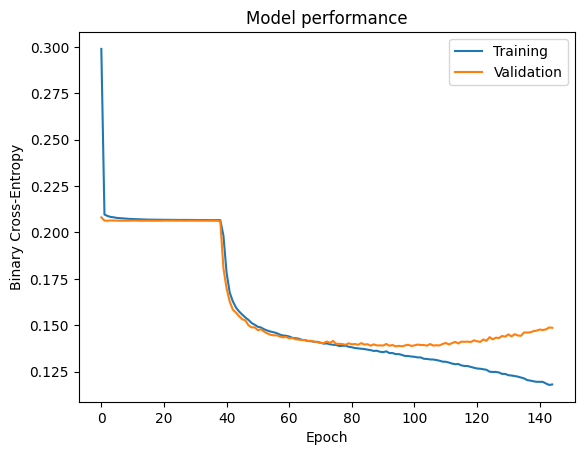

In [106]:
plt.plot(hist.history['loss'], label="Training")
plt.plot(hist.history['val_loss'], label="Validation")  ### waaaaay overfitting
plt.legend()
plt.title('Model performance')
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy")
plt.savefig("modelperformance_binarycrossentropy_singlelabel.png")
plt.savefig("modelperformance_binarycrossentropy_singlelabel.svg")

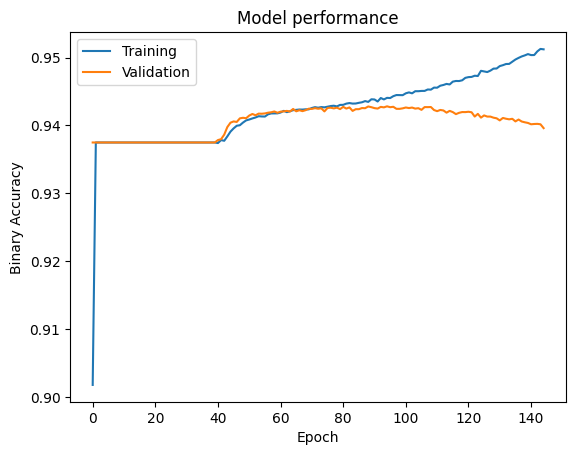

In [107]:
plt.plot(hist.history['binary_accuracy'], label="Training")
plt.plot(hist.history['val_binary_accuracy'], label="Validation")  ### waaaaay overfitting
plt.legend()
plt.title('Model performance')
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.savefig("modelperformance_binaryaccuracy_singlelabel.png")
plt.savefig("modelperformance_binaryaccuracy_singlelabel.svg")

In [48]:
preds = model.predict(X_test)

1152/1152 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


In [58]:
preds_label = np.argmax(preds, axis=1)

In [60]:
ytest_label = np.argmax(y_test, axis=1)

In [61]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

In [83]:
import matplotlib.patches

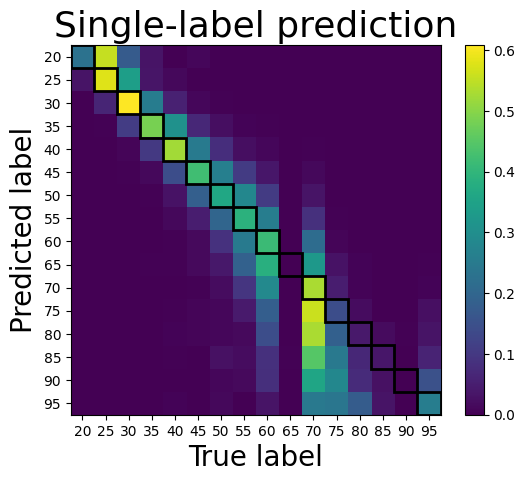

In [105]:
fig, ax = plt.subplots(1,1)
im0 = ax.imshow(confusion_matrix(ytest_label, preds_label, normalize='true'), origin="upper")
plt.xticks(np.arange(16), xcols)
plt.yticks(np.arange(16), xcols)
plt.xlabel("True label", fontsize=20)
plt.ylabel("Predicted label", fontsize=20)
fig.colorbar(im0, ax=ax)
# Create a square patch
for i in range(16):
    rect = matplotlib.patches.Rectangle((-0.5+i, -0.5+i), 1, 1, linewidth=2, edgecolor='k', facecolor='none')
    ax.add_patch(rect)
# Add the patch to the plot
plt.title("Single-label prediction", fontsize=26)
plt.savefig("singlelabel_confusion_inverted.svg")
plt.savefig("singlelabel_confusion_inverted.png")